# CutOutDonuts with WEP

Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach))
<br>Last Verified to Run: **2024-01-04**
<br>Software Versions:
  - `ts_wep`: **v8.0.3**
  - `lsst_distrib`: **w_2023_47**

## Notebook Objective

This notebooks shows how to cut out the donut postage stamps for a detector using `cutOutDonutsCwfsTask`. It walks through the available configuration settings and shows how to run it from the command line as part of a Gen 3 middleware pipeline.

## Logistics

This notebook is intended to be run on the USDF RSP: https://usdf-rsp.slac.stanford.edu/.

### Data

The donut catalogs for this notebook were created by `GenerateDonutCatalogWcsTask` from images created by imSim and stored in the shared AOS butler repository (`/sdf/group/rubin/repo/aos_imsim`). The collection with the data used in this notebook is `u/brycek/ts_analysis_notebooks/wep_v8.0.3`. The raw images and the Gaia DR2 reference catalog (`gaia_dr2_20200414`) used to generate the images are available for access in the same butler on the USDF. For more information on `GenerateDonutCatalogWcsTask` see the notebook [wepSourceSelectionWithWcs](wepSourceSelectionWithWcs.ipynb).

## Imports

In [1]:
from lsst.daf.butler import Butler

from lsst.ts.wep.utils import runProgram, writePipetaskCmd
from lsst.ts.wep.task import CutOutDonutsCwfsTask, CutOutDonutsCwfsTaskConfig

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Cut Out Donuts

Given the catalogs for each chip and the postISRCCD exposures we can run the `CutOutDonutsCwfsTask` or `CutOutDonutsScienceSensorTask` to get the postage stamp cutouts of each donut in `DonutStamp` format.

### Configure the `CutOutDonuts...Task`

Here we will go through the available configuration settings when running the task.

In [2]:
cutOutConfig = CutOutDonutsCwfsTaskConfig()

In [3]:
print(cutOutConfig)

{'saveMetadata': True, 'saveLogOutput': True, 'donutTemplateSize': 160, 'donutStampSize': 160, 'initialCutoutPadding': 5, 'opticalModel': 'offAxis', 'instObscuration': 0.61, 'instFocalLength': 10.312, 'instApertureDiameter': 8.36, 'instDefocalOffset': None, 'instPixelSize': 1e-05, 'multiplyMask': False, 'maskGrowthIter': 6, 'connections': {'exposures': 'postISRCCD', 'donutCatalog': 'donutCatalog', 'camera': 'camera', 'donutStampsExtra': 'donutStampsExtra', 'donutStampsIntra': 'donutStampsIntra'}}


#### Available configuration settings

* `donutTemplateSize`: Size in pixels of template used for centroiding the donuts. Default=160.
* `donutStampSize`: Size of the donut stamps in pixels. Default=160.
* `initialCutoutPadding`: Additional padding in pixels on each side of the initial postage stamp before centroiding. Default=5.
* `opticalModel`: Specify the optical model ('offAxis', 'paraxial', 'onAxis').

#### Changing Configuration Setting in Interactive Mode

The configuration settings can be changed interactively:

In [4]:
print(cutOutConfig.initialCutoutPadding)

5


In [5]:
cutOutConfig.initialCutoutPadding = 10
print(cutOutConfig.initialCutoutPadding)

10


### Running the task

#### Load the data

Running this task requires the following input data:

* `postISRCCD`: The `postISRCCD` exposures for the intra and extra-focal exposures. 
* `donutCatalog`: The `donutCatalog` for both the intra and extra-focal exposures.
* `camera`: The `camera` object store in the butler repository.

In [6]:
# Initiate the task with our given configuration
cutOutTask = CutOutDonutsCwfsTask(config=cutOutConfig)

In [7]:
# Repository with closed loop data
butler_repo = '/sdf/group/rubin/repo/aos_imsim'
# Initialize the butler to get the donut catalogs and postISR exposures
butler = Butler(butler_repo)
registry = butler.registry

In [8]:
# Specify the data Ids for the data in the repository
dataIdExtra = {'instrument': 'LSSTCam', 'detector': 191, 'exposure': 5024072300034, 'visit': 5024072300034}
dataIdIntra = {'instrument': 'LSSTCam', 'detector': 192, 'exposure': 5024072300034, 'visit': 5024072300034}

In [9]:
# Load the donut catalogs
donutCatalogExtra = butler.get('donutCatalog', dataId=dataIdExtra, collections=['u/brycek/ts_analysis_notebooks/wep_v8.0.3'])
donutCatalogIntra = butler.get('donutCatalog', dataId=dataIdIntra, collections=['u/brycek/ts_analysis_notebooks/wep_v8.0.3'])

In [10]:
# Load the postISR exposures
isrOutExtra = butler.get('postISRCCD', dataId=dataIdExtra, collections=['u/brycek/ts_analysis_notebooks/wep_v8.0.3'])
isrOutIntra = butler.get('postISRCCD', dataId=dataIdIntra, collections=['u/brycek/ts_analysis_notebooks/wep_v8.0.3'])

In [11]:
# Get the camera model
camera = butler.get('camera', {'instrument': 'LSSTCam'}, collections=['LSSTCam/calib/unbounded'])

#### Run the task

In [12]:
# Run the CutOutDonuts task
cutOutOutput = cutOutTask.run(
    [isrOutExtra, isrOutIntra],
    [donutCatalogExtra, donutCatalogIntra],
    camera
)

The final output of the task is a `struct` with two different datasets:
* `donutStampsExtra`: This is a `donutStamps` object that contains postage stamps and location information of the extra-focal donuts selected for use in the Zernike estimation.
* `donutStampsIntra`: This is a `donutStamps` object that contains postage stamps and location information of the intra-focal donuts selected for use in the Zernike estimation.

In [13]:
donutStampsExtra = cutOutOutput.donutStampsExtra

Text(0, 0.5, 'Y Pixels')

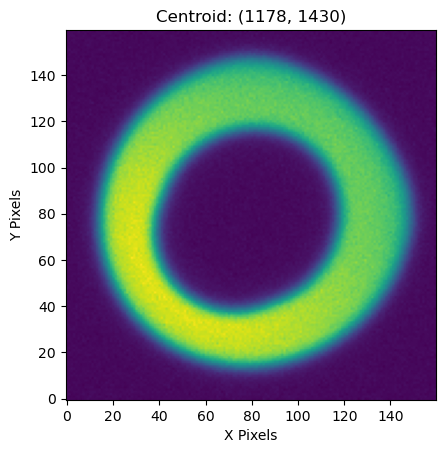

In [14]:
plt.imshow(donutStampsExtra[0].stamp_im.getImage().getArray(), origin='lower')
plt.title(f'Centroid: {donutStampsExtra[0].centroid_position}')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

### Running as a pipeline task

This notebooks showed how to run `CutOutStampsCwfsTask` interactively. To run in a full Gen3 processing pipeline you can use `CutOutStampsCwfsTask` and set the configuration with a pipeline file. An example of a pipeline file that runs the full pipeline up starting from `raw` files up to `CutOutStampsCwfsTask` looks like the following:

```   
# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing in ts_wep.
description: wep basic processing test pipeline
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.LsstCam
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    # Below we specify the configuration settings we want to use
    # when running the task in this pipeline. Since our data doesn't
    # include bias or flats we only want to use doApplyGains and
    # doOverscan in our isr task.
    config:
      connections.outputExposure: 'postISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains: True
      doFringe: False
      doOverscan: True
  generateDonutCatalogWcsTask:
    class: lsst.ts.wep.task.generateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
    config:
      connections.refCatalogs: 'ps1_pv3_3pi_20170110'
  cutOutDonutsCwfsTask:
    class: lsst.ts.wep.task.cutOutDonutsCwfsTask.CutOutDonutsCwfsTask
    config:
      # And here we specify the configuration settings originally defined in
      # EstimateZernikesCwfsTaskConfig.
      donutTemplateSize: 160
      donutStampSize: 160
      initialCutoutPadding: 40
```

And a possible entry on the command line would be:

`pipetask run -b $PATH_TO_BUTLER_REPO -i $COLLECTION_NAMES -d "exposure in ($EXPOSURE_IDS)" -p $PIPELINE_CONFIGURATION_FILE --instrument lsst.obs.lsst.LsstCam  --register-dataset-types --output-run $OUTPUT_RUN_NAME `

* `-b` points to your repository
* `-i` names the collections where your calibration and raw data are located in the repository
* `-d` specify a data selection query here
* `-p` the path to the configuration file like the sample above
* `--instrument` specify the instrument for your data
* `--register-dataset-types` registers any dataset types that don't already exist in the registry
* `--output-run` specifies the name of the new output collection